# Hyperparameter tuning

To improve the performance of our model, we need to delve into the realm of hyperparameter tuning. Hyperparameters are settings that we can adjust to optimize the behavior and accuracy of our machine learning model, to fine-tune it's performance. 

The previous model was trained with certain default hyperparameter values, which serve as a baseline. However, these default values may not always yield the best results for our specific problem.

Hyperparameter tuning involves systematically exploring different combinations of hyperparameter values to find the optimal configuration that maximizes our model's performance. This process is often iterative and involves training and evaluating the model multiple times with different hyperparameter settings.

In [1]:
import sys
sys.path.insert(0, './src')
import utils



import albumentations as A
import os
import torch
import torch.nn as nn
import warnings
import torch.utils.data as data
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning) # Masks are not georeferences, so we can ignore this warning
warnings.filterwarnings("ignore", category=UserWarning) # This will throw a warning message about cudnn, this is normal (https://github.com/pytorch/pytorch/pull/125790)

We'll reimport the default values that we had from before

Using PyTorch version: 2.3.0+cu121  Device: cuda
PyTorch version:  2.3.0+cu121
CUDA version:  12.1
cuDNN version:  8902
Image shape: torch.Size([16, 3, 300, 300]), Mask shape: torch.Size([16, 1, 300, 300])


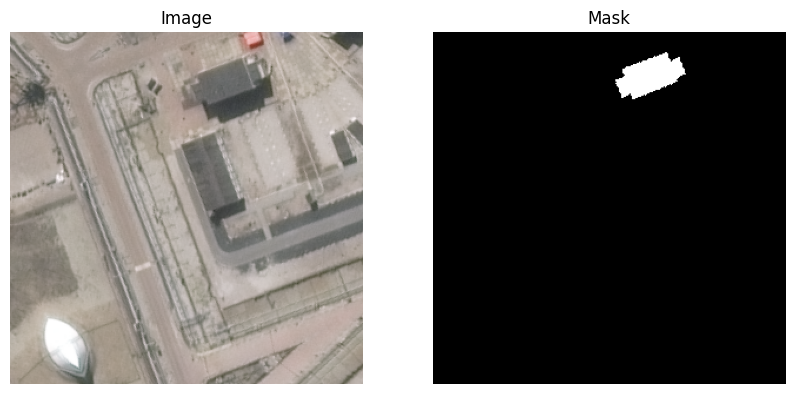

In [2]:
# MEAN = [63.02235933, 66.64201154, 60.63862196]
# STD = [55.50368184, 55.35826425, 52.63471437]
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
INITIAL_LR = 1e-5 # Should try with a higher LR to see what happens, hoping that the model won't explode uwu
MAX_LR = 1e-3
SIZE = 300
NUM_WORKERS = 8
BATCH_SIZE = 16
EPOCHS = 8
LOSS_PROPORTION = 0.5
LOAD_BEST = False

# Let's define some paths
DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"

device = utils.set_cuda_and_seed()

print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())


train_transforms = A.Compose([
    A.RandomCrop(SIZE, SIZE),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
])

eval_transforms = A.Compose([
    A.Resize(SIZE, SIZE), 
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0)
])

from dataset import SN6Dataset

train_dataset = SN6Dataset(DATASET_PATH, transform=train_transforms, split='train')
eval_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='val')
test_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='test')

train_loader = data.DataLoader(train_dataset, pin_memory = True, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
eval_loader = data.DataLoader(eval_dataset, pin_memory = True, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = data.DataLoader(test_dataset, pin_memory = True, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

image, mask = next(iter(train_loader))
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
utils.visualize_image(image[0], mask[0])

We'll be trying something new: A custom loss function that connects both BCEWithLogitLoss and a custom-made Dice loss (since we already established it's our best parameter) in a 50/50 mix. It's been implemented in _custom_loss.py_

we'll try to work on 
 - Normalization
 - A better Segmentation
 - Maybe slowing down the learning rate even further
 

In [3]:
from model import UNET

model = UNET(in_channels = 3, out_channels = 1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=1e-5)

# We won't use a scheduler at first, but we'll add it later
# torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS, anneal_strategy='cos')
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS, anneal_strategy='cos')
scaler = torch.cuda.amp.GradScaler()




One of the things I've noticed in the training is how hard it's for the model to track small buildings, this is because to make our batch_size higher a downscale was necessary; we modified some values, changing:
 - SIZE to 300x300
 - BATCH_SIZE to 8

In [4]:
from train import train

best_f1 = 0.0
history = {
    'train_loss': [],
    'val_loss': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': []
}

last_epoch = 0
if LOAD_BEST:
    print("Restoring best model")
    if(os.path.exists(CHECKPOINT_PATH + "best.pth")):
        history, last_epoch = utils.load_checkpoint(CHECKPOINT_PATH + "best_2.pth", model, optimizer, scheduler)
        best_f1 = max(history['f1'])
    else:
        print("Best model not found, starting from scratch")

# Training model
for epoch in range(last_epoch, EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_loss = train(train_loader, model, optimizer, criterion, scaler, scheduler, device)
    # Detect if loss is NaN, and immediately stop with a ValueError 
    
    
    eval_loss, precision, recall, f1, accuracy = utils.get_evals(eval_loader, model, criterion, device, save_predictions=True, output_path="data/eval")
    history['train_loss'].append(train_loss)
    history['val_loss'].append(eval_loss)
    history['precision'].append(precision)
    history['recall'].append(recall)
    history['f1'].append(f1)
    history['accuracy'].append(accuracy)
    print(f"Train loss: {train_loss:.4f} Eval loss: {eval_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f} Accuracy: {accuracy:.4f}")
    # Save model
    checkpoint = {
        "history" : history,
        "epoch" : epoch,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": criterion.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + "checkpoint_2.pth")
    if f1 > best_f1:
        best_f1 = f1
        utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + "best_2.pth")
        print("Best model saved")

    if epoch - 5 > 0: # Value of validation loss is increasing, model is overfitting. Need to stop training
        if history['val_loss'][epoch] > history['val_loss'][epoch-1] > history['val_loss'][epoch-2] > history['val_loss'][epoch-3] > history['val_loss'][epoch-4]:
            print("Early stopping")
            break
print("Finished training! Well done :3\nQuitting...")

Epoch 1 of 8


Loss: 0.3164: 100%|██████████| 170/170 [10:18<00:00,  3.64s/it]

Saving predictions to: data/eval


Train loss: 0.4702 Eval loss: 0.6976 Precision: 0.5124 Recall: 0.3290 F1: 0.4007 Accuracy: 0.9332
saving checkpoint
saving checkpoint
Best model saved
Epoch 2 of 8


Loss: 0.2210: 100%|██████████| 170/170 [11:26<00:00,  4.04s/it]


Saving predictions to: data/eval
Train loss: 0.2479 Eval loss: 0.6947 Precision: 0.4633 Recall: 0.0708 F1: 0.1228 Accuracy: 0.9314
saving checkpoint
Epoch 3 of 8


Loss: 0.1763: 100%|██████████| 170/170 [11:10<00:00,  3.94s/it]


Saving predictions to: data/eval
Train loss: 0.1914 Eval loss: 0.6932 Precision: 0.6102 Recall: 0.0630 F1: 0.1142 Accuracy: 0.9337
saving checkpoint
Epoch 4 of 8


Loss: 0.2066: 100%|██████████| 170/170 [10:29<00:00,  3.70s/it]

Saving predictions to: data/eval


Train loss: 0.1712 Eval loss: 0.6931 Precision: 0.6214 Recall: 0.0045 F1: 0.0089 Accuracy: 0.9322
saving checkpoint
Epoch 5 of 8


Loss: 0.2756:  80%|████████  | 136/170 [08:22<02:05,  3.69s/it]


In [ ]:
import matplotlib.pyplot as plt

# Get the history
history, _ = utils.load_checkpoint(CHECKPOINT_PATH + "checkpoint.pth", model)
image, mask, pred = utils.get_random_image(eval_loader, model, device)
utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = GRAPH_PATH + "tuning.png")

train_loss = history['train_loss']
eval_loss = history['val_loss']
precision = history['precision']
recall = history['recall']
accuracy = history['accuracy']
f1_score = history['f1']
# Plot the loss and other metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(accuracy, label='Accuracy')
plt.plot(f1_score, label='F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig(GRAPH_PATH + "metrics_tuning.png")
plt.show()